In [13]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import display, Markdown

In [14]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [15]:
app_train = pd.read_csv(DATASET_DIR / "application_train.csv")
bureau = pd.read_csv(DATASET_DIR / "bureau.csv")
description = pd.read_csv(DATASET_DIR / "HomeCredit_columns_description.csv", encoding="latin", index_col=0)

In [16]:
# Schnittmenge zwischen app_train und bureau
# Ergänzt die Variable "TARGET" in dem bureau-Datensatz
bureau = pd.merge(bureau, app_train[["SK_ID_CURR","TARGET"]] ,on="SK_ID_CURR")

In [17]:
# Zeitreihen
ts = ["DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT"]
# for head in ts:
#     bureau[head] = bureau[head] * -1

In [18]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,0


In [19]:
quants = [0, 0.25, 0.5, 0.75, 1]
for index, head in enumerate(ts):
    a = bureau[["SK_ID_CURR", head]]
    a = a.groupby(by = ["SK_ID_CURR"]).quantile(quants)
    a = a.unstack(level=-1)
    if index == 0:
        z = a
        continue
    z = pd.merge(a, z , on="SK_ID_CURR")
z.head()

DAYS_ENDDATE_FACT                                 \
                        0.00     0.25   0.50    0.75   1.00   
SK_ID_CURR                                                    
100002               -1185.0 -1020.25 -939.0 -263.75  -36.0   
100003               -2131.0 -1376.00 -621.0 -580.50 -540.0   
100004                -683.0  -607.75 -532.5 -457.25 -382.0   
100007                -783.0  -783.00 -783.0 -783.00 -783.0   
100008               -1028.0  -968.50 -909.0 -849.50 -790.0   

           DAYS_CREDIT_ENDDATE                                  \
                          0.00     0.25   0.50    0.75    1.00   
SK_ID_CURR                                                       
100002                 -1072.0 -1006.25 -424.5   79.25   780.0   
100003                 -2434.0 -1013.50 -480.0  -11.00  1216.0   
100004                  -595.0  -541.75 -488.5 -435.25  -382.0   
100007                  -783.0  -783.00 -783.0 -783.00  -783.0   
100008                  -853.0  -822.50 -792.0 -160.50   471.0   

           CREDIT_DAY_OVERDUE                     DAYS_CREDIT                  \
                         0.00 0.25 0.50 0.75 1.00        0.00    0.25    0.50   
SK_ID_CURR                                                                      
100002                    0.0  0.0  0.0  0.0  0.0     -1437.0 -1122.0 -1042.5   
100003                    0.0  0.0  0.0  0.0  0.0     -2586.0 -1873.5 -1205.5   
100004                    0.0  0.0  0.0  0.0  0.0     -1326.0 -1096.5  -867.0   
100007                    0.0  0.0  0.0  0.0  0.0     -1149.0 -1149.0 -1149.0   
100008                    0.0  0.0  0.0  0.0  0.0     -1097.0 -1097.0 -1097.0   

                             
               0.75    1.00  
SK_ID_CURR                   
100002      -602.75  -103.0  
100003      -732.75  -606.0  
100004      -637.50  -408.0  
100007     -1149.00 -1149.0  
100008      -587.50   -78.0

In [20]:
app_train = pd.merge(z, app_train,on="SK_ID_CURR")

c:\users\rober\documents\workspace\python\masterarbeit\venv\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
app_train.head()

,SK_ID_CURR,"(DAYS_ENDDATE_FACT, 0.0)","(DAYS_ENDDATE_FACT, 0.25)","(DAYS_ENDDATE_FACT, 0.5)","(DAYS_ENDDATE_FACT, 0.75)","(DAYS_ENDDATE_FACT, 1.0)","(DAYS_CREDIT_ENDDATE, 0.0)","(DAYS_CREDIT_ENDDATE, 0.25)","(DAYS_CREDIT_ENDDATE, 0.5)","(DAYS_CREDIT_ENDDATE, 0.75)","(DAYS_CREDIT_ENDDATE, 1.0)","(CREDIT_DAY_OVERDUE, 0.0)","(CREDIT_DAY_OVERDUE, 0.25)","(CREDIT_DAY_OVERDUE, 0.5)","(CREDIT_DAY_OVERDUE, 0.75)","(CREDIT_DAY_OVERDUE, 1.0)","(DAYS_CREDIT, 0.0)","(DAYS_CREDIT, 0.25)","(DAYS_CREDIT, 0.5)","(DAYS_CREDIT, 0.75)","(DAYS_CREDIT, 1.0)",TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,-1185.0,-1020.25,-939.0,-263.75,-36.0,-1072.0,-1006.25,-424.5,79.25,780.0,0.0,0.0,0.0,0.0,0.0,-1437.0,-1122.0,-1042.5,-602.75,-103.0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-2131.0,-1376.00,-621.0,-580.50,-540.0,-2434.0,-1013.50,-480.0,-11.00,1216.0,0.0,0.0,0.0,0.0,0.0,-2586.0,-1873.5,-1205.5,-732.75,-606.0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851

In [22]:
n_heads = ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
m_heads = ['CNT_CHILDREN','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
md_heads = ['CNT_CHILDREN', "CNT_FAM_MEMBERS","HOUR_APPR_PROCESS_START", "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE","AMT_REQ_CREDIT_BUREAU_HOUR","AMT_REQ_CREDIT_BUREAU_DAY","AMT_REQ_CREDIT_BUREAU_WEEK","AMT_REQ_CREDIT_BUREAU_MON","AMT_REQ_CREDIT_BUREAU_QRT","AMT_REQ_CREDIT_BUREAU_YEAR"]
ms_heads = [head for head in m_heads if head not in md_heads]

In [23]:
# transformiert kategorische variablen in integer
for head in n_heads:
    app_train[head], cats = pd.factorize(app_train[head])

In [24]:
y = app_train["TARGET"]
x = app_train.drop(["SK_ID_CURR", "TARGET"], axis=1)

In [25]:
# ersätzt alle np.nan durch 0
x = x.fillna(0)

In [26]:
# unterteilt den trainingsdatensatz in trainings- und validierungsdatensätze
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)

In [34]:
model = RandomForestClassifier(max_depth=7, random_state=0)

In [35]:
model.fit(x,y)

RandomForestClassifier(max_depth=7, random_state=0)

In [36]:
# Prognosewerte der Testdaten
model.predict(x_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [37]:
# Prognosewerte der Testdaten in %
x_test_prob = model.predict_proba(x_test)
x_test_prob

array([[0.11346637, 0.88653363],
       [0.15389891, 0.84610109],
       [0.0604054 , 0.9395946 ],
       ...,
       [0.02718873, 0.97281127],
       [0.16295669, 0.83704331],
       [0.18561647, 0.81438353]])

In [38]:
# Durchschnittliche Trefferwahrscheinlichkeit
model.score(x_test, y_test)

0.9236257647291

In [39]:
# Erstellung der AUC & ROC-Metrik
# Wahrscheinlichkeiten für keinen Kreditausfall
prob = x_test_prob[:,1]
auc = roc_auc_score(y_test, prob)
print(auc)
# FalsePositiveRate, TruePositiveRate & Treshold 
fpr, tpr, threshold = roc_curve(y_test, prob)

0.7507888747959293


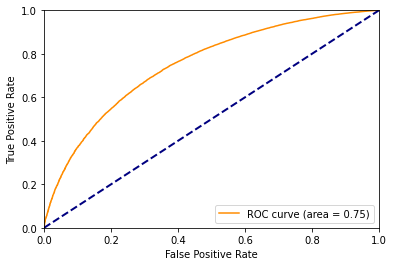

In [40]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()